In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

data_dir = '/content/drive/MyDrive/GEE_Kaski'  # Adjust if saved in a subfolder


In [ ]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.2 MB/s eta 0:00:00


In [ ]:
import os
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling

# File names (make sure they match exactly)
files = [
    'kaski_elevation_30m.tif',
    'kaski_slope_30m.tif',
    'kaski_aspect_30m.tif',
    'kaski_precipitation_30m.tif'
]

file_paths = [os.path.join(data_dir, f) for f in files]

# Use elevation as reference
ref_path = file_paths[0]
with rasterio.open(ref_path) as ref_src:
    ref_shape = ref_src.shape
    ref_transform = ref_src.transform
    ref_crs = ref_src.crs
    ref_meta = ref_src.meta

# Stack rasters (resample only precipitation)
stacked = []
for path in file_paths:
    with rasterio.open(path) as src:
        if src.shape != ref_shape:
            print(f"Resampling {os.path.basename(path)} from {src.shape} → {ref_shape}")
            data = np.empty(ref_shape, dtype=src.dtypes[0])
            reproject(
                source=rasterio.band(src, 1),
                destination=data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.bilinear
            )
        else:
            print(f"Reading {os.path.basename(path)} as-is")
            data = src.read(1)
        stacked.append(data)

# Stack to (bands, height, width)
stacked_array = np.stack(stacked, axis=0)
print("✅ Final stacked array shape:", stacked_array.shape)


Reading kaski_elevation_30m.tif as-is
Reading kaski_slope_30m.tif as-is
Reading kaski_aspect_30m.tif as-is
Resampling kaski_precipitation_30m.tif from (1990, 2146) → (1989, 2147)
✅ Final stacked array shape: (4, 1989, 2147)


In [ ]:

# Use metadata from one raster
with rasterio.open(file_paths[0]) as src:
    meta = src.meta.copy()

# Update metadata
meta.update({
    'count': 4,
    'driver': 'GTiff'  # Make sure driver is set
})

# Output path
out_path = os.path.join(data_dir, 'kaski_stack_4band.tif')

# Save stacked raster
with rasterio.open(out_path, 'w', **meta) as dst:
    for i in range(4):
        dst.write(stacked_array[i].astype(meta['dtype']), i + 1)

print("✅ Saved stacked raster to:", out_path)



<ipython-input-37-2308e5828953>:17: RuntimeWarning: invalid value encountered in cast
  dst.write(stacked_array[i].astype(meta['dtype']), i + 1)


✅ Saved stacked raster to: /content/drive/MyDrive/GEE_Kaski/kaski_stack_4band.tif


In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import os

# Paths
data_dir = '/content/drive/MyDrive/GEE_Kaski'
stack_path = os.path.join(data_dir, 'kaski_stack_4band.tif')
landslide_path = os.path.join(data_dir, 'kaski_landslides.geojson')
non_landslide_path = os.path.join(data_dir, 'kaski_non_landslides.geojson')

# Load GeoJSON files
gdf_ls = gpd.read_file(landslide_path)
gdf_nonls = gpd.read_file(non_landslide_path)

# Assign labels
gdf_ls['label'] = 1
gdf_nonls['label'] = 0

# Combine datasets
gdf_all = gpd.GeoDataFrame(pd.concat([gdf_ls, gdf_nonls], ignore_index=True))

# Get (x, y) coordinates from point geometries
coords = [(geom.x, geom.y) for geom in gdf_all.geometry]

# Sample raster at those coordinates using the raster's own method
with rasterio.open(stack_path) as src:
    sampled_vals = np.array([val for val in src.sample(coords)])

# Features and labels
X = sampled_vals
y = gdf_all['label'].values

# Check output
print("✅ Sampled X shape:", X.shape)  # (n_samples, 4)
print("✅ Labels y shape:", y.shape)   # (n_samples,)
print("✅ First 5 samples:\n", X[:5])
print("✅ First 5 labels:\n", y[:5])


✅ Sampled X shape: (73, 4)
✅ Labels y shape: (73,)
✅ First 5 samples:
 [[1636   21  246 2354]
 [ 682    3  164 2518]
 [1450   15  176 2429]
 [ 904   21  237 2942]
 [1020   32  240 2707]]
✅ First 5 labels:
 [1 1 1 1 1]


In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Check class balance
class_counts = Counter(y)
print("Class distribution:", class_counts)

# Optionally balance the dataset (undersample majority)
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

print("Balanced class counts:", Counter(y_balanced))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, random_state=42
)

print("✅ X_train shape:", X_train.shape)
print("✅ y_train shape:", y_train.shape)


Class distribution: Counter({np.int64(0): 46, np.int64(1): 27})
Balanced class counts: Counter({np.int64(0): 27, np.int64(1): 27})
✅ X_train shape: (43, 4)
✅ y_train shape: (43,)


In [ ]:
# PyTorch should already be installed in Colab, but run this to make sure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


Epoch 1/200 - Loss: 0.7958
Epoch 2/200 - Loss: 0.7466
Epoch 3/200 - Loss: 0.6738
Epoch 4/200 - Loss: 0.7043
Epoch 5/200 - Loss: 0.6391
Epoch 6/200 - Loss: 0.6293
Epoch 7/200 - Loss: 0.6375
Epoch 8/200 - Loss: 0.5871
Epoch 9/200 - Loss: 0.5899
Epoch 10/200 - Loss: 0.5558
Epoch 11/200 - Loss: 0.5373
Epoch 12/200 - Loss: 0.5187
Epoch 13/200 - Loss: 0.5597
Epoch 14/200 - Loss: 0.5488
Epoch 15/200 - Loss: 0.5571
Epoch 16/200 - Loss: 0.5327
Epoch 17/200 - Loss: 0.4874
Epoch 18/200 - Loss: 0.4551
Epoch 19/200 - Loss: 0.4435
Epoch 20/200 - Loss: 0.4824
Epoch 21/200 - Loss: 0.5146
Epoch 22/200 - Loss: 0.4608
Epoch 23/200 - Loss: 0.4713
Epoch 24/200 - Loss: 0.5038
⏹️ Early stopping triggered.

✅ Test Accuracy: 0.6667

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.7500    0.7059         8
           1     0.6667    0.5714    0.6154         7

    accuracy                         0.6667        15
   macro avg     0.6667    0.6607    0.

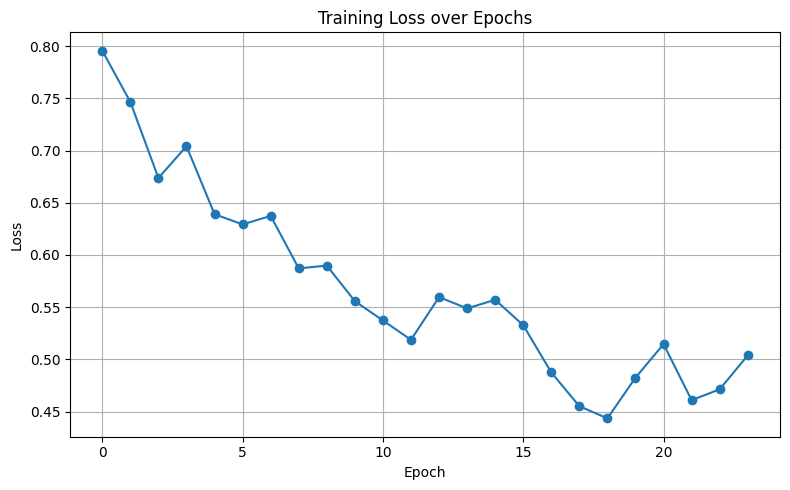

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # ✅ Add this import
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ------------------------
# Step 1: Normalize and Prepare Data
# ------------------------

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# ------------------------
# Step 2: Define MLP Model
# ------------------------

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)  # Binary classification (landslide vs non-landslide)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
model = MLP(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------
# Step 3: Train Model with Early Stopping
# ------------------------

epochs = 200
best_loss = float('inf')
patience = 5
counter = 0
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model_state)

# ------------------------
# Step 4: Evaluate Model
# ------------------------

model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    pred_labels = preds.argmax(dim=1)
    accuracy = (pred_labels == y_test_tensor).float().mean().item()

print(f"\n✅ Test Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test_tensor.numpy(), pred_labels.numpy(), digits=4))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test_tensor.numpy(), pred_labels.numpy()))

# ------------------------
# Step 5: Plot Training Loss
# ------------------------

plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np

# Step 1: Flatten raster (4, H, W) -> (H*W, 4)
c, h, w = stacked_array.shape
X_full = stacked_array.reshape(c, -1).T  # shape: (H*W, 4)

# Step 2: Normalize using the same scaler used during training
X_full_scaled = scaler.transform(X_full)

# Step 3: Convert to PyTorch tensor
X_full_tensor = torch.tensor(X_full_scaled, dtype=torch.float32)

# Step 4: Predict with trained model (get probability for class 1 = landslide)
model.eval()
with torch.no_grad():
    output_probs = torch.softmax(model(X_full_tensor), dim=1)  # shape: (H*W, 2)
    landslide_probs = output_probs[:, 1].numpy()  # probability of class 1 (landslide)

# Step 5: Reshape back to raster
susceptibility_map = landslide_probs.reshape(h, w)
print("✅ Susceptibility map shape:", susceptibility_map.shape)


✅ Susceptibility map shape: (1989, 2147)


In [ ]:
import rasterio

# Use metadata from one of the original rasters
with rasterio.open(file_paths[0]) as src:
    meta = src.meta.copy()
    meta.update({
        'count': 1,
        'dtype': 'float32',
        'driver': 'GTiff'
    })

# Output path
output_path = os.path.join(data_dir, 'kaski_susceptibility_map.tif')

# Save
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(susceptibility_map.astype('float32'), 1)

print(f"✅ Saved susceptibility map to: {output_path}")



✅ Saved susceptibility map to: /content/drive/MyDrive/GEE_Kaski/kaski_susceptibility_map.tif


In [ ]:
import rasterio
import numpy as np

# Load the susceptibility map (GeoTIFF) again
sus_path = os.path.join(data_dir, 'kaski_susceptibility_map.tif')

with rasterio.open(sus_path) as src:
    susceptibility = src.read(1)

print("✅ Susceptibility map loaded. Shape:", susceptibility.shape)



✅ Susceptibility map loaded. Shape: (1989, 2147)


In [ ]:
# Classify into 5 classes
classified = np.zeros_like(susceptibility)

classified[(susceptibility >= 0.0) & (susceptibility < 0.2)] = 1  # Very Low
classified[(susceptibility >= 0.2) & (susceptibility < 0.4)] = 2  # Low
classified[(susceptibility >= 0.4) & (susceptibility < 0.6)] = 3  # Medium
classified[(susceptibility >= 0.6) & (susceptibility < 0.8)] = 4  # High
classified[susceptibility >= 0.8] = 5                            # Very High


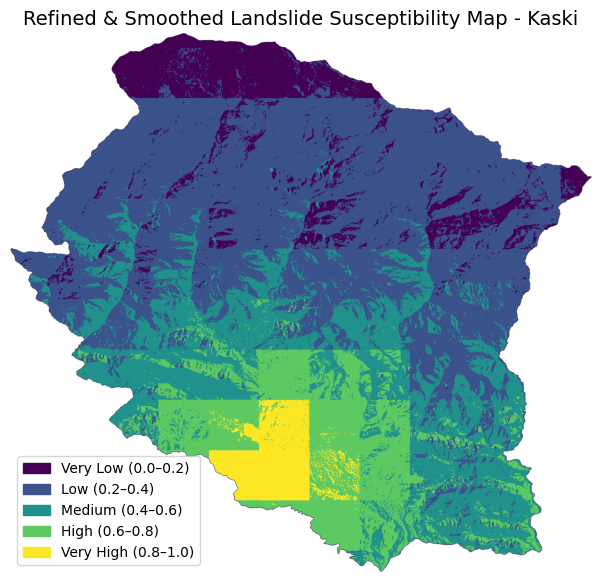

✅ Saved refined high-contrast map to: /content/drive/MyDrive/GEE_Kaski/kaski_susceptibility_refined_highcontrast.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy.ndimage import median_filter, gaussian_filter
import os

# ------------------ Step 1: Classify into 5 Contrast Zones ------------------
classified = np.zeros_like(susceptibility_map)

classified[(susceptibility_map >= 0.0) & (susceptibility_map < 0.2)] = 1  # Very Low
classified[(susceptibility_map >= 0.2) & (susceptibility_map < 0.4)] = 2  # Low
classified[(susceptibility_map >= 0.4) & (susceptibility_map < 0.6)] = 3  # Medium
classified[(susceptibility_map >= 0.6) & (susceptibility_map < 0.8)] = 4  # High
classified[susceptibility_map >= 0.8] = 5                                 # Very High

# ------------------ Step 2: Apply Smoothing ------------------
classified_median = median_filter(classified, size=3)
classified_smooth = gaussian_filter(classified_median.astype(float), sigma=0.6)  # optional

# Round back to nearest class (1–5)
classified_final = np.rint(classified_smooth).astype(int)

# ------------------ Step 3: Custom High-Contrast Colormap ------------------
# Colorblind-friendly, high-contrast colormap
colors = [
    'white',        # 0 - nodata
    '#440154',      # 1 - Very Low (dark purple)
    '#3b528b',      # 2 - Low (indigo)
    '#21918c',      # 3 - Medium (teal)
    '#5ec962',      # 4 - High (light green)
    '#fde725'       # 5 - Very High (bright yellow)
]
cmap = mcolors.ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5, 6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# ------------------ Step 4: Legend ------------------
legend_patches = [
    mpatches.Patch(color='#440154', label='Very Low (0.0–0.2)'),
    mpatches.Patch(color='#3b528b', label='Low (0.2–0.4)'),
    mpatches.Patch(color='#21918c', label='Medium (0.4–0.6)'),
    mpatches.Patch(color='#5ec962', label='High (0.6–0.8)'),
    mpatches.Patch(color='#fde725', label='Very High (0.8–1.0)')
]

# ------------------ Step 5: Plot ------------------
fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')
masked = np.ma.masked_where(classified_final == 0, classified_final)
im = ax.imshow(masked, cmap=cmap, norm=norm)

ax.set_title("Refined & Smoothed Landslide Susceptibility Map - Kaski", fontsize=14)
ax.axis('off')
ax.legend(handles=legend_patches, loc='lower left', facecolor='white', frameon=True)

# Save high-res PNG
output_path = os.path.join(data_dir, 'kaski_susceptibility_refined_highcontrast.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Saved refined high-contrast map to: {output_path}")
